# Analysis of the behavior of mobile application users

## Project description

The customer is a startup that sells food products. It is necessary to analyze how users of the mobile application behave.
Study the sales funnel, find out how users reach the purchase. How many users reach the purchase, and how many get “stuck” at the previous steps, on which ones.

Then explore the results of the A/A/B experiment. The designers wanted to change the fonts throughout the application, and the managers suggested that it would be unusual for users.
Users were divided into 3 groups: 2 control groups with old fonts and one experimental group with new ones. You need to decide which font is best.

### Data Description

Each entry in the log is a user action, or event.
* EventName - event name;
* DeviceIDHash - unique user identifier;
* EventTimestamp - event time;
* ExpId is the number of the experiment: 246 and 247 are the control groups, and 248 is the experimental group.

## Data quality analysis

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('logs_exp.csv', sep='\t')
data.head(3)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# duplicates
data.duplicated().sum()

413

In [5]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [6]:
# rename the column names for convenience
data = data.rename (columns= {'EventTimestamp': 'event_time', 
       'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'ExpId': 'exp_id'})

In [7]:
data.head()

,event_name,user_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [8]:
# let's bring the column with the date to the desired format
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

In [9]:
# add a separate column with only the date
data['event_date'] = data['event_time'].dt.date
data.head()

,event_name,user_id,event_time,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [10]:
# how many users are in the log
data['user_id'].nunique()

7551

In [11]:
data['event_name'].count()

243713

In [12]:
# how many events per user on average
display(round(data.shape[0]/data['user_id'].nunique()))

32

In [13]:
# display statistics on the number of events per user
data_pivot_table = data.pivot_table(index='user_id', values='event_name', aggfunc='count')
data_pivot_table.describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


In [14]:
# minimum and maximum date
display(data['event_date'].min())
display(data['event_date'].max())

datetime.date(2019, 7, 25)

datetime.date(2019, 8, 7)

Let's see how the events were distributed in time.

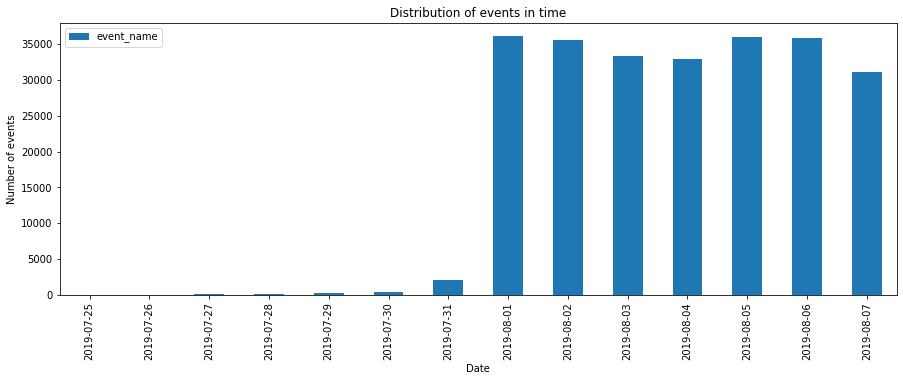

In [15]:
data.groupby('event_date').agg({'event_name':'count'}).plot(kind='bar', figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Number of events')
plt.title('Distribution of events in time');

Events in time are unevenly distributed in the dataset. Technically, in the logs of new days for some users, events from the past can “reach” - this can “skew the data”. User activity begins on August 1, 2019.
In this regard, for further analysis, we will filter the data from August 1 to August 7, 2019.

In [16]:
cut_date = pd.to_datetime('2019-08-01') 
pd.to_datetime(data['event_date'])
data = data.set_index(['event_date'])
data = data.loc[cut_date:]

In [17]:
# how many users lost after date filtering?
data['user_id'].nunique()

7534

After filtering dates, only 17 users lost, 0.2%

In [18]:
# how many lines have been removed?
before_filtered = 243713 #df after removing 413 duplicates
after_filtered = data['user_id'].count()
data_delited = before_filtered - after_filtered
display(data_delited)
data_delited_perc = (1-after_filtered/before_filtered)*100
display(data_delited_perc.round(1))

2826

1.2

In [19]:
# check that there are users from all three experimental groups
data.pivot_table(index='exp_id', values='user_id', aggfunc='nunique')

,user_id
exp_id,
246,2484
247,2513
248,2537


Yes, there are users in all three experimental groups.

Conclusion on data quality analysis:

1. There were no gaps in the original data, but there were 413 duplicates, they were removed.
2. The column with the date and time is brought to the desired format, and the names of the columns are replaced with understandable ones.
3. Unique users in the log 7551 (after date filter 7534), on average there are 32 events per user.
4. The dataset contains events from July 25 to August 7, 2019. However, the period of active use of the application is from August 1. Therefore, the data is filtered from 1 to 7 August. As a result of filtering, the number of unique users decreased by 0.2%.

## Event funnel analysis

At this step, we will analyze the behavior of users at different stages of using the application.

Let's see what events are in the logs and how often they occur.

In [20]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

The log contains the following events:

* Appearance of the main screen
* Offers appear on the screen
* Cart screen will appear
* Appearance screens with successful payment
* Manual/instruction

Most often, the event of the appearance of the main screen occurs, least often - users open the instruction.

Let's count how many users made each of these events; sort events by the number of users; Calculate the proportion of users who have made an event at least once.

In [21]:
total = data['user_id'].nunique()
user_event = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
user_event = user_event.to_frame().reset_index()
user_event['%'] = user_event['user_id']/total
user_event.style.format({'%':'{:.1%}'})

,event_name,user_id,%
0,MainScreenAppear,7419,98.5%
1,OffersScreenAppear,4593,61.0%
2,CartScreenAppear,3734,49.6%
3,PaymentScreenSuccessful,3539,47.0%
4,Tutorial,840,11.1%


7419 users have ever opened the home page: 98% of all users. 61% went to the page with offers, 50% added to the cart, 47% paid.

Let's assume the order in which events occur; whether they all line up in a sequential chain.

Sales funnel:

Appearance of the main screen -> Appearance of the catalog with goods on the screen -> Appearance of the screen with a shopping cart
  -> Appearance of the screen with successful payment

The Tutorial step is not related to the main flow of events (purchase funnel), and judging by the number of events at this step for unique users, most people skip this step. 

Let's calculate what percentage of users go to the next step of the funnel.

,user_id,conversion,previous_step,step_conversion
event_name,,,,
MainScreenAppear,7419,1.000000,NaN,NaN
OffersScreenAppear,4593,0.619086,7419.0,0.619086
CartScreenAppear,3734,0.503302,4593.0,0.812976
PaymentScreenSuccessful,3539,0.477018,3734.0,0.947777


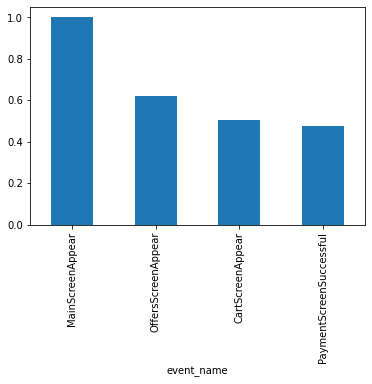

In [22]:
report = data.query('event_name != "Tutorial"').groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
report['conversion'] = report['user_id']/report['user_id'].values[0]
report['previous_step'] = report['user_id'].shift()
report['step_conversion'] = report['user_id'] / report['previous_step']#conversion to next step
display(report)
report['conversion'].plot(kind='bar');

Most users are lost at the step of transition from the main page to the catalog with goods: 62% of users reach the catalog with goods. 48% of users make it from the first event to payment.

Conclusions on the analysis of the funnel of events:
1. Events pass in the following order

Appearance of the main screen -> Appearance of the catalog with goods on the screen -> Appearance of the screen with a shopping cart
  -> Appearance of the screen with successful payment

2. Only 11% of users use training, this step does not apply to the purchase funnel.
3. Most of the users are lost when they go to the product catalog, and 48% of users reach the step with payment.

## Analysis of A/B test results

In this section:
* check the correctness of the calculations on the control groups for the A / A experiment
* let's choose a somae popular event and calculate the number of users who made this event in each of the control groups, as well as the share of users who made this event; check if the difference between the groups is statistically significant
* compare the results of groups with different fonts.

In [23]:
# number of users in each experimental group
data.pivot_table(index='exp_id', values='user_id', aggfunc='nunique')

,user_id
exp_id,
246,2484
247,2513
248,2537


There are 2 control groups for the A / A experiment, to check the correctness of all mechanisms and calculations, we will check if the statistical criteria find a difference between samples 246 and 247.

The number of users in group 247 differs from the number of users in group 246 by 1%. The difference, of course, is not critical, but it is better to make the groups the same, so the test turns out to be of optimal duration.

Let's check that a user who is in one group remains in it until the end of the experiment using the set() function, which selects unique values from the list.
We will pass to it a list of users belonging to group 246, and using the intersection operator with
group 247, we get a set of users falling into both groups.

If the set is empty, then there are no intersections.

In [24]:
set(data[data['exp_id'] == 246]['user_id']) & set(data[data['exp_id'] == 247]['user_id'])

set()

There are no intersections.

Let's choose the most popular event and count the number of users who made this event in each of the control groups.

In [25]:
trials = data.groupby('exp_id').agg({'user_id':'nunique'})
display(trials)
funnel = data.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique')
display(funnel) # the number of users who committed an event in each of the control groups

,user_id
exp_id,
246,2484
247,2513
248,2537


exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


The event performed by the largest number of users is the Main Screen, i.e. the opening of the main page. It is made by 98% of users of each group (% of events made by users was found in section 3).

For all events, we will check whether the difference between groups 246 and 247 is statistically significant.

Let's formulate hypotheses.

But: There is no statistically significant difference in purchase conversion between groups; no differences between groups

H1: The conversion funnel in groups is different

In [26]:
def check_hypothesis(successes1, successes2, trials1, trials2):
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined)*(1/trials1 + 1/trials2))
    distr = stats.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [27]:
# apply the function
alpha = 0.01

for event in['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 246], funnel.loc[event, 247],
                        trials.loc[246].values[0], trials.loc[247].values[0]) < alpha:
        trig = 'significant'
    else:
        trig = 'not significant'
        print(f"Difference between groups 246 and 247 by event {event} statistically {trig}, p-value= ",
               check_hypothesis(funnel.loc[event,246], funnel.loc[event,247],
                               trials.loc[246].values[0], trials.loc[247].values[0]))

Difference between groups 246 and 247 by event MainScreenAppear statistically not significant, p-value=  0.7570597232046099
Difference between groups 246 and 247 by event OffersScreenAppear statistically not significant, p-value=  0.2480954578522181
Difference between groups 246 and 247 by event CartScreenAppear statistically not significant, p-value=  0.22883372237997213
Difference between groups 246 and 247 by event PaymentScreenSuccessful statistically not significant, p-value=  0.11456679313141849


Conclusion: there are no statistically significant differences between groups 246 and 247 for all events, the groups are formed correctly.

Let's compare the results of each of the control groups (246, 247) with the group with a changed font (248)

Let's formulate hypotheses.

But: There is no statistically significant difference in purchase conversion between groups after changing the font; there are no differences between the groups before and after the font change

H1: The conversion funnel in groups after changing the font is different

In [28]:
alpha = 0.01

for event in['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 246], funnel.loc[event, 248],
                        trials.loc[246].values[0], trials.loc[248].values[0]) < alpha:
        trig = 'significant'
    else:
        trig = 'not significant'
        print(f"Difference between groups 246 and 248 by event {event} statistically {trig}, p-value= ",
               check_hypothesis(funnel.loc[event,246], funnel.loc[event,248],
                               trials.loc[246].values[0], trials.loc[248].values[0]))

Difference between groups 246 and 248 by event MainScreenAppear statistically not significant, p-value=  0.2949721933554552
Difference between groups 246 and 248 by event OffersScreenAppear statistically not significant, p-value=  0.20836205402738917
Difference between groups 246 and 248 by event CartScreenAppear statistically not significant, p-value=  0.07842923237520116
Difference between groups 246 and 248 by event PaymentScreenSuccessful statistically not significant, p-value=  0.2122553275697796


In [29]:
alpha = 0.01

for event in['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 247], funnel.loc[event, 248],
                        trials.loc[247].values[0], trials.loc[248].values[0]) < alpha:
        trig = 'significant'
    else:
        trig = 'not significant'
        print(f"Difference between groups 246 and 248 by event {event} statistically {trig}, p-value= ",
               check_hypothesis(funnel.loc[event,247], funnel.loc[event,248],
                               trials.loc[247].values[0], trials.loc[248].values[0]))

Difference between groups 246 and 248 by event MainScreenAppear statistically not significant, p-value=  0.4587053616621515
Difference between groups 246 and 248 by event OffersScreenAppear statistically not significant, p-value=  0.9197817830592261
Difference between groups 246 and 248 by event CartScreenAppear statistically not significant, p-value=  0.5786197879539783
Difference between groups 246 and 248 by event PaymentScreenSuccessful statistically not significant, p-value=  0.7373415053803964


Сравним результаты с объединённой контрольной группой

In [30]:
# form a united group
combined = data.query('exp_id in [246, 247]')
combined['exp_id'] = '246 + 247'

# add to the main data
data_new = data.append(combined)

# form a funnel
trials = data_new.groupby('exp_id').agg({'user_id':'nunique'})
display(trials)
funnel = data_new.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique')
display(funnel)

,user_id
exp_id,
246,2484
247,2513
248,2537
246 + 247,4997


exp_id,246,247,248,246 + 247
event_name,,,,
CartScreenAppear,1266,1238,1230,2504
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [31]:
alpha = 0.01

for event in['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 248], funnel.loc[event, '246 + 247'],
                        trials.loc[248].values[0], trials.loc['246 + 247'].values[0]) < alpha:
        trig = 'significant'
    else:
        trig = 'not significant'
        print(f"Difference between groups 248 and 246+247 by event {event} statistically {trig}, p-value= ",
               check_hypothesis(funnel.loc[event,248], funnel.loc[event,'246 + 247'],
                               trials.loc[248].values[0], trials.loc['246 + 247'].values[0]))

Difference between groups 248 and 246+247 by event MainScreenAppear statistically not significant, p-value=  0.29424526837179577
Difference between groups 248 and 246+247 by event OffersScreenAppear statistically not significant, p-value=  0.43425549655188256
Difference between groups 248 and 246+247 by event CartScreenAppear statistically not significant, p-value=  0.18175875284404386
Difference between groups 248 and 246+247 by event PaymentScreenSuccessful statistically not significant, p-value=  0.6004294282308704


Conclusion: after all the tests carried out - no result showed a statistically significant difference between groups 246,247 and 248.

The significance level for testing statistical hypotheses was chosen as 0.01.

Tests of statistical hypotheses were made:

Number of group combinations: 4 (246 and 247; 246 and 248; 247 and 248; 246+247 and 248) multiplied by the number of conversions: 4 (MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful).

Total 4 * 4 = 16 checks.

Let's check the result with the combined control group taking into account the Bonferroni correction.

In [32]:
alpha = 0.01
bonferroni_alpha = alpha / 16

for event in['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if check_hypothesis(funnel.loc[event, 248], funnel.loc[event, '246 + 247'],
                        trials.loc[248].values[0], trials.loc['246 + 247'].values[0]) < bonferroni_alpha:
        trig = 'significant'
    else:
        trig = 'not significant'
        print(f"Difference between groups 248 and 246+247 by event {event} statistically {trig}, p-value= ",
               check_hypothesis(funnel.loc[event,248], funnel.loc[event,'246 + 247'],
                               trials.loc[248].values[0], trials.loc['246 + 247'].values[0]))

Difference between groups 248 and 246+247 by event MainScreenAppear statistically not significant, p-value=  0.29424526837179577
Difference between groups 248 and 246+247 by event OffersScreenAppear statistically not significant, p-value=  0.43425549655188256
Difference between groups 248 and 246+247 by event CartScreenAppear statistically not significant, p-value=  0.18175875284404386
Difference between groups 248 and 246+247 by event PaymentScreenSuccessful statistically not significant, p-value=  0.6004294282308704


The result has not changed, which is logical, because. at the selected significance level of 0.01, the null hypothesis is not rejected in any comparison.

## Conclusions

As a result of the analysis of the behavior of users of the mobile application, it was found that
Most users are lost at the step of transition from the main page to the catalog with goods: 62% of users reach the catalog with goods. 48% of users make it from the first event to payment.

The results of A / A and A / B tests were studied (determining the impact of changing the font on user behavior). The following conclusions were obtained:

1. The results of the A / A test showed that the groups for analysis were formed correctly, no statistically significant difference was found between them.
2. 3 combinations of test results were tested (in addition to control groups). There was no statistically significant difference between the groups in any test.

Managers' fears that users would be unaccustomed to using the changed font, according to the results of the A / B test, did not materialize.